In [53]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Set paths
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
# ======= Define Paths =======
MODEL_PATH = "/content/drive/My Drive/Clothing Segmentation/checkpoints/unet_best.h5"
SAMPLE_IMAGE_PATH = "/content/drive/My Drive/Clothing Segmentation/sample_inputs/sample1.jpg"  # Update with your sample image path
LABELS_CSV_PATH = "/content/drive/My Drive/Clothing Segmentation/dataset/labels.csv"  # CSV with 59 classes

In [56]:
# ======= Parameters =======
IMG_HEIGHT, IMG_WIDTH = 256, 256  # Size expected by the model
NUM_CLASSES = 59  # Total number of classes

In [57]:
# ======= Load Class Names =======
# Assuming labels.csv has a column named 'label_list' with class names for 59 classes
if os.path.exists(LABELS_CSV_PATH):
    class_df = pd.read_csv(LABELS_CSV_PATH)
    class_names = class_df['label_list'].tolist()
    print("Loaded class names from CSV.")
else:
    # Fallback: Generate dummy class names
    class_names = [f"Class_{i}" for i in range(NUM_CLASSES)]
    print("CSV not found, using default class names.")

Loaded class names from CSV.


In [58]:
# ======= Generate Colormap for 59 Classes =======
# Using 'hsv' colormap from Matplotlib for distinct colors
cmap = plt.cm.get_cmap('hsv', NUM_CLASSES)
# Extract RGB values and scale them to [0, 255]
colormap = (cmap(np.arange(NUM_CLASSES))[:, :3] * 255).astype(np.uint8)

<ipython-input-58-e6900f94baab>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', NUM_CLASSES)


In [59]:
# ======= Load Trained Model =======
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully from:", MODEL_PATH)

Model loaded successfully from: /content/drive/My Drive/Clothing Segmentation/checkpoints/unet_best.h5


In [60]:
# ======= Preprocess Input Image =======
def preprocess_image(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Load and preprocess the input image."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Image not found at path: {image_path}")
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize image to target size
    image = cv2.resize(image, target_size)
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    # Add batch dimension
    image = np.expand_dims(image, axis=0)
    return image

In [74]:
# ======= Inference =======
input_image = preprocess_image(SAMPLE_IMAGE_PATH)
# Model prediction returns shape (1, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
predicted_mask = model.predict(input_image)[0]
# Convert predictions to class indices per pixel
pred_class = np.argmax(predicted_mask, axis=-1)  # Shape: (IMG_HEIGHT, IMG_WIDTH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [64]:
# ======= Create Colored Segmentation Mask =======
def colorize_mask(mask, colormap, num_classes=NUM_CLASSES):
    """Convert the predicted class indices mask to a colored segmentation mask."""
    # Ensure mask values are in valid range
    mask = np.clip(mask, 0, num_classes - 1)
    # Create an RGB mask where each pixel's value is replaced by its color from the colormap
    colored_mask = colormap[mask]
    return colored_mask

In [65]:
colored_mask = colorize_mask(pred_class, colormap, NUM_CLASSES)

In [75]:
# ======= For Visualization: Resize Original Image =======
original_image = cv2.imread(SAMPLE_IMAGE_PATH)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image = cv2.resize(original_image, (IMG_WIDTH, IMG_HEIGHT))

In [76]:
# ======= Create Blended Output =======
blended = cv2.addWeighted(original_image, 0.6, colored_mask, 0.4, 0)


In [70]:
# ======= Overlay Class Labels on Mask =======
def overlay_class_labels(mask, image):
    """Overlay class indices as text on the segmentation mask."""
    output_image = image.copy()
    unique_classes = np.unique(mask)

    for class_idx in unique_classes:
        if class_idx == 0:  # Ignore background (assuming 0 is background)
            continue
        y, x = np.where(mask == class_idx)
        if len(y) > 0:
            center_x, center_y = int(np.mean(x)), int(np.mean(y))
            label_text = str(class_idx)
            cv2.putText(output_image, label_text, (center_x, center_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return output_image

In [77]:
labeled_mask = overlay_class_labels(pred_class, colored_mask)

# ======= Display the Results =======
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

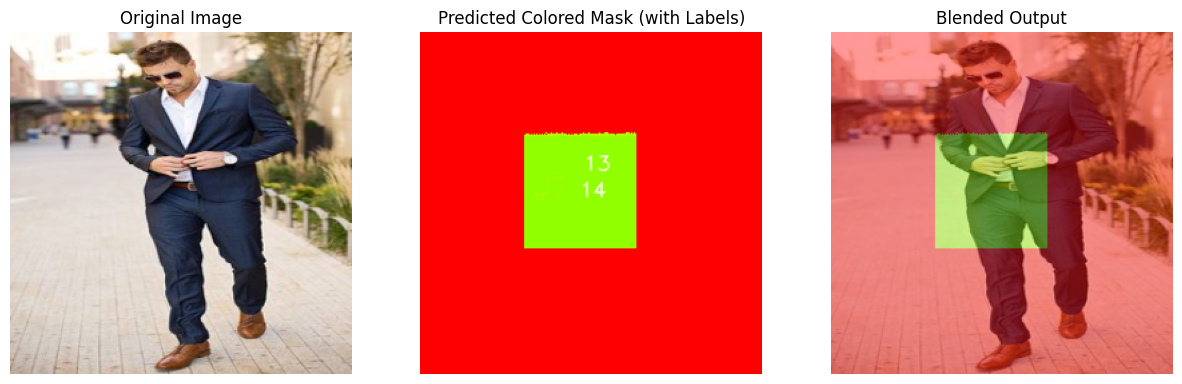


Detected Classes in Prediction:
Class 0: nan
Class 13: coat
Class 14: dress


In [78]:
# ======= Display the Results =======
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Predicted Colored Mask (with Labels)")
plt.imshow(labeled_mask)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Blended Output")
plt.imshow(blended)
plt.axis("off")

plt.show()

# ======= Print Class Index Mapping =======
unique_classes = np.unique(pred_class)
print("\nDetected Classes in Prediction:")
for class_idx in unique_classes:
    print(f"Class {class_idx}: {class_names[class_idx]}")